# Numba 模組的練習題

## 練習題 1：使用 @jit 加速矩陣元素相加
### 題目描述：<br>
寫一個函數計算兩個相同大小的 NumPy 陣列（元素逐一相加），並使用 Numba 的 @jit 裝飾器來加速。<br>
假設矩陣為a和b大小是1000x1000的隨機浮點數(```np.random.random((n, n)).astype(np.float32), n=1000```)<br>
比較使用和不使用 Numba 的執行時間。

## 練習題 2：使用 @vectorize 實現自訂元素級運算
### 題目描述：
撰寫一個函數，對輸入陣列的每個元素進行自訂運算：如果元素大於 0.5，則返回其平方；否則返回其兩倍。<br>
使用 Numba 的 @vectorize 裝飾器，並比較與純 NumPy 版本的效能。輸入陣列大小為 1,000,000。

## 練習題 3：使用 CUDA 加速矩陣內積
### 題目描述：
實現兩個 3x224x224 矩陣的內積，使用 Numba 的 CUDA 支援來加速計算。<br>
假設矩陣為a和b大小是3x224x224 的隨機浮點數(np.random.random((3,224,224)).astype(np.float32))<br>
並且要預先宣告GPU輸出的array。<br>
比較純 NumPy 版本和 CUDA 版本的執行時間，和比較兩者輸出是否有差異。假設你有支援 CUDA 的 GPU。<br>

Note: NumPy 版本:<br>
```
def matrix_inner_product_numpy(a, b):
    return np.sum(a * b, axis=(1, 2))
```

## 練習題 4：使用 @vectorize 實現批量距離計算並支援 CUDA
### 題目描述：
計算兩個點集之間的歐幾里得距離（每對點的距離）。<br>
點集為 N=100,000 個二維點，使用 Numba 的 @vectorize 並支援 CPU 和 CUDA 兩種模式<br>
比較三種版本（NumPy、CPU vectorize、CUDA vectorize）的效能和比較兩者輸出是否有差異。

---------------------以下為解答----------------------

----- 練習題 1 -----

In [ ]:
'''
## 練習題 1：使用 @jit 加速矩陣元素相加
### 題目描述：<br>
寫一個函數計算兩個相同大小的 NumPy 陣列（元素逐一相加），並使用 Numba 的 @jit 裝飾器來加速。<br>
假設矩陣為a和b大小是1000x1000的隨機浮點數(np.random.random((n, n)).astype(np.float32), n=1000)
比較使用和不使用 Numba 的執行時間。
'''
import numpy as np
from numba import jit
import time

# 使用 Numba 加速的版本
@jit(nopython=True)
def add_arrays(a, b):
    result = np.zeros_like(a)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            result[i, j] = a[i, j] + b[i, j]
    return result

# 測試程式碼
n = 1000
a = np.random.random((n, n)).astype(np.float32)
b = np.random.random((n, n)).astype(np.float32)

# 測試 Python 版本
start = time.time()
result_numba = add_arrays.py_func(a, b)
numba_time = time.time() - start
print(f"Python 版本時間: {numba_time:.4f} 秒")

# 測試 Numba 版本（第一次執行包含編譯時間）
start = time.time()
result_numba = add_arrays(a, b)
numba_time = time.time() - start
print(f"Numba 版本時間 (含編譯): {numba_time:.4f} 秒")

# 再次執行 Numba 版本（僅運行時間）
start = time.time()
result_numba = add_arrays(a, b)
numba_time = time.time() - start
print(f"Numba 版本時間 (僅運行): {numba_time:.4f} 秒")

Python 版本時間: 0.3915 秒
Numba 版本時間 (含編譯): 0.1445 秒
Numba 版本時間 (僅運行): 0.0030 秒


----- 練習題 2 -----

In [16]:
'''
## 練習題 2：使用 @vectorize 實現自訂元素級運算
### 題目描述：
撰寫一個函數，對輸入陣列的每個元素進行自訂運算：如果元素大於 0.5，則返回其平方；否則返回其兩倍。<br>
使用 Numba 的 @vectorize 裝飾器(用float32來進行輸入和輸出)，並比較與純 NumPy 版本的效能。輸入陣列大小為 1,000,000。
'''
import numpy as np
from numba import vectorize
import time

# 純 NumPy 版本
def custom_op_numpy(x):
    return np.where(x > 0.5, x**2, 2*x)

# Numba vectorize 版本
@vectorize(['float32(float32)'])
def custom_op_numba(x):
    if x > 0.5:
        return x * x
    else:
        return 2 * x

# 測試程式碼
n = 1_000_000
x = np.random.random(n).astype(np.float32)

# 測試 NumPy 版本
start = time.time()
result_numpy = custom_op_numpy(x)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 測試 Numba 版本
start = time.time()
result_numba = custom_op_numba(x)
numba_time = time.time() - start
print(f"Numba 版本時間: {numba_time:.4f} 秒")



NumPy 版本時間: 0.0308 秒
Numba 版本時間: 0.0132 秒


----- 練習題 3 -----

In [52]:
'''
## 練習題 3：使用 CUDA 加速矩陣內積
### 題目描述：
實現兩個 3x224x224 矩陣的內積，使用 Numba 的 CUDA 支援來加速計算。<br>
假設矩陣為a和b大小是3x224x224 的隨機浮點數(np.random.random((3,224,224)).astype(np.float32))<br>
並且要預先宣告GPU輸出的array。<br>
比較純 NumPy 版本和 CUDA 版本的執行時間，和比較兩者輸出是否有差異。假設你有支援 CUDA 的 GPU。<br>

Note: NumPy 版本:<br>
```
def matrix_inner_product_numpy(a, b):
    return np.sum(a * b, axis=(1, 2))
```
'''

import numpy as np
from numba import cuda
import time

# NumPy 版本
def matrix_inner_product_numpy(a, b):
    return np.sum(a * b, axis=(1, 2))

# CUDA 版本
@cuda.jit
def matrix_inner_product_cuda(a, b, out):
    # 獲取執行緒索引
    batch = cuda.blockIdx.z
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    # 檢查索引範圍
    if batch < out.shape[0] and row < a.shape[1] and col < a.shape[2]:
        # 每個執行緒計算一個元素乘積
        value = a[batch, row, col] * b[batch, row, col]
        # 使用原子操作累加到輸出
        cuda.atomic.add(out, batch, value)

# 測試程式碼
batch_size = 3
n = 512
a = np.random.random((batch_size, n, n)).astype(np.float32)
b = np.random.random((batch_size, n, n)).astype(np.float32)
out = np.zeros(batch_size, dtype=np.float32)

# 傳輸到 GPU
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
out_device = cuda.to_device(out)

# 配置網格和區塊
threadsperblock = (16, 16)  # 16x16 區塊
blockspergrid_x = (n + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (n + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y, batch_size)

# 測試 NumPy 版本
start = time.time()
result_numpy = matrix_inner_product_numpy(a, b)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 測試 CUDA 版本
start = time.time()
matrix_inner_product_cuda[blockspergrid, threadsperblock](a_device, b_device, out_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間(含編譯): {cuda_time:.4f} 秒")


# 複製結果回主機
result_cuda = out_device.copy_to_host()

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))
print("NumPy 結果:", result_numpy)
print("CUDA 結果:", result_cuda)


NumPy 版本時間: 0.0020 秒
CUDA 版本時間(含編譯): 0.0777 秒
結果是否一致: False
NumPy 結果: [65535.445 65470.82  65714.06 ]
CUDA 結果: [65533.76  65470.043 65713.29 ]


----- 練習題 4 -----

In [ ]:
'''
## 練習題 4：使用 @vectorize 實現批量距離計算並支援 CUDA
### 題目描述：
計算兩個點集之間的歐幾里得距離（每對點的距離）。<br>
點集為 N=100,000 個二維點，使用 Numba 的 @vectorize 並支援 CPU 和 CUDA 兩種模式<br>
比較三種版本（NumPy、CPU vectorize、CUDA vectorize）的效能和比較兩者輸出是否有差異。
'''
import numpy as np
from numba import vectorize
from numba import cuda
import math
import time

# NumPy 版本
def euclidean_distance_numpy(points1, points2):
    return np.sqrt(np.sum((points2 - points1)**2, axis=1))

# CPU vectorize 版本
@vectorize(['float32(float32, float32, float32, float32)'])
def euclidean_distance_cpu(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# CUDA vectorize 版本
@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def euclidean_distance_cuda(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# 測試程式碼
n = 100_000
points1 = np.random.random((n, 2)).astype(np.float32)
points2 = np.random.random((n, 2)).astype(np.float32)
x1, y1 = points1[:, 0], points1[:, 1]
x2, y2 = points2[:, 0], points2[:, 1]

# 確保陣列連續
x1 = np.ascontiguousarray(x1)
y1 = np.ascontiguousarray(y1)
x2 = np.ascontiguousarray(x2)
y2 = np.ascontiguousarray(y2)

# 傳輸到 GPU
x1_device = cuda.to_device(x1)
y1_device = cuda.to_device(y1)
x2_device = cuda.to_device(x2)
y2_device = cuda.to_device(y2)

# 測試 NumPy 版本
start = time.time()
dist_numpy = euclidean_distance_numpy(points1, points2)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 測試 CPU vectorize 版本
start = time.time()
dist_cpu = euclidean_distance_cpu(x1, y1, x2, y2)
cpu_time = time.time() - start
print(f"CPU vectorize 版本時間: {cpu_time:.4f} 秒")

# 測試 CUDA vectorize 版本
start = time.time()
dist_cuda = euclidean_distance_cuda(x1_device, y1_device, x2_device, y2_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA vectorize 版本時間: {cuda_time:.4f} 秒")

# 驗證結果
dist_cuda_host = dist_cuda.copy_to_host()
print("結果是否一致:", np.allclose(dist_numpy, dist_cpu) and np.allclose(dist_numpy, dist_cuda_host))

NumPy 版本時間: 0.0020 秒
CPU vectorize 版本時間: 0.0009 秒
CUDA vectorize 版本時間: 0.0740 秒
結果是否一致: True


Note:注意事項<br>
```x1 = np.ascontiguousarray(x1)``` <br>
```x1_device = cuda.to_device(x1)```<br>

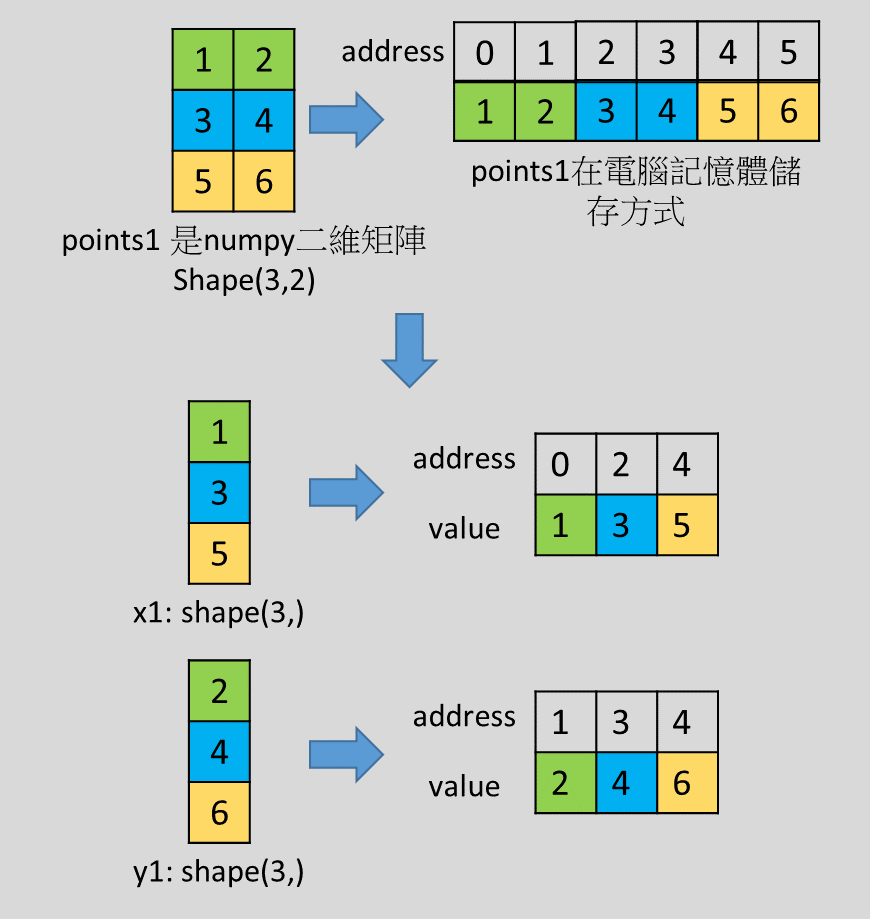

X是C contiguous的，因為矩陣在記憶體是行優先的，即某個元素在記憶體中的下一個位置儲存的是它同行的下一個值。<br>
因為我們x1, y1 = points1[:, 0], points1[:, 1]，所以我們取出來的x1其實記憶體不是連續的<br>
如果我們沒有處理要直接放到GPU的時候，因為記憶體不連續會出錯。<br>
所以要透過```np.ascontiguousarray```處理記憶體存放。<br>


In [36]:
x1, y1 = points1[:, 0], points1[:, 1]
print(x1.flags)
x1 = np.ascontiguousarray(x1)
print(x1.flags)


  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

